<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cooler-Python-API" data-toc-modified-id="Cooler-Python-API-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cooler Python API</a></span><ul class="toc-item"><li><span><a href="#Direct-access-with-h5py" data-toc-modified-id="Direct-access-with-h5py-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Direct access with <code>h5py</code></a></span></li><li><span><a href="#The-Cooler-class" data-toc-modified-id="The-Cooler-class-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>The <code>Cooler</code> class</a></span><ul class="toc-item"><li><span><a href="#The-info-dictionary" data-toc-modified-id="The-info-dictionary-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>The info dictionary</a></span></li><li><span><a href="#Table-Views" data-toc-modified-id="Table-Views-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Table Views</a></span></li><li><span><a href="#Bin-annotation" data-toc-modified-id="Bin-annotation-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Bin annotation</a></span></li><li><span><a href="#Enter-The-Matrix" data-toc-modified-id="Enter-The-Matrix-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Enter The Matrix</a></span></li><li><span><a href="#Balancing-your-selection" data-toc-modified-id="Balancing-your-selection-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Balancing your selection</a></span></li><li><span><a href="#Genomic-coordinate-range-selection" data-toc-modified-id="Genomic-coordinate-range-selection-1.2.6"><span class="toc-item-num">1.2.6&nbsp;&nbsp;</span>Genomic coordinate range selection</a></span></li></ul></li></ul></li></ul></div>

# Cooler Python API

Pre-requisites:

- Basic Python knowledge
- Some experience with the NumPy array package (or MATLAB)

This walkthrough also makes use of:

- Jupyter (IPython) Notebook. That's what you're using right now!
- Pandas, the dataframe package (similar to R data.frames)
- h5py, the package to interact with HDF5 files from Python
- matplotlib, the MATLAB-inspired plotting package for Python

To navigate this notebook:

- Click on a code cell and execute its code by pressing `shift+enter` or clicking the "play" button on the toolbar.
- While the code cell is running the prompt on the left will look like `In [*]:` and will display the execution count when it is done.
- Execution output will be displayed beneath each cell.
- To restart the notebook, use the options in the `Kernel` dropdown menu.
- You can also run the entire notebook in one go with the `Restart & Run All` option

In [1]:
# Import the packages we will use
import matplotlib.pyplot as plt
import numpy as np
import pandas
import h5py

import cooler

In [2]:
# The following directive activates inline plotting
%matplotlib inline

In [3]:
filepath = 'data/Rao2014-GM12878-MboI-allreps-filtered.5kb.cool'

# Download a high resoltion COOL file from the interwebs (this will take a few...)
# The ! at the beginning of the line tells IPython to run the line in the shell.
!wget ftp://cooler.csail.mit.edu/coolers/hg19/Rao2014-GM12878-MboI-allreps-filtered.5kb.cool -O {filepath}

## Direct access with `h5py`

The `h5py` library (HDF5 for Python) provides an excellent Pythonic interface between HDF5 and native [NumPy](http://www.numpy.org/) arrays and dtypes. It allows you to treat an HDF5 file like a dictionary with complete access to the file's contents as well as the ability to manipulate groups and read or write datasets and attributes. There is additionally a low-level API that wraps the `libhdf5` C functions directly. See the [h5py docs](http://docs.h5py.org/en/latest/index.html).

In [4]:
h5 = h5py.File(filepath, 'r')

In [5]:
h5

<HDF5 file "Rao2014-GM12878-MboI-allreps-filtered.5kb.cool" (mode r)>

In [6]:
h5.keys()

<KeysViewHDF5 ['bins', 'chroms', 'indexes', 'pixels']>

Files and Groups are `dict`-like.

In [7]:
h5['pixels']

<HDF5 group "/pixels" (3 members)>

In [8]:
list(h5['pixels'].keys())

['bin1_id', 'bin2_id', 'count']

`h5py` dataset objects are **views** onto the data on disk

In [9]:
h5['pixels']['bin2_id']

<HDF5 dataset "bin2_id": shape (1543535265,), type "<i8">

Slicing or indexing returns a numpy array in memory.

In [10]:
h5['pixels']['bin2_id'][:10]

array([  234,  1994,  3258,  4087,  6093, 37359, 49826, 49889, 58451,
       60826])

In [11]:
h5['pixels']['count'][:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [12]:
h5.close()

The Python `cooler` package is just a thin wrapper over `h5py`.

- It lets you access the data tables as [Pandas](http://pandas.pydata.org/) [data frames and series](http://pandas.pydata.org/pandas-docs/stable/10min.html). 
- It also provides a _matrix abstraction_: letting you query the upper triangle pixel table as if it were a full rectangular [sparse matrix](http://www.scipy-lectures.org/advanced/scipy_sparse/storage_schemes.html) via [SciPy](http://www.scipy-lectures.org/index.html).

See below.

## The `Cooler` class

Accepts a file path or an open HDF5 file object.

NOTE: Using a filepath allows the `Cooler` object to be serialized/pickled since the file is only opened when needed.


In [13]:
c = cooler.Cooler(filepath)

### The info dictionary

In [14]:
c.info

{'bin-size': 5000,
 'bin-type': 'fixed',
 'creation-date': '2016-02-25T22:53:09.510744',
 'format-url': 'https://github.com/mirnylab/cooler',
 'format-version': 2,
 'genome-assembly': 'hg19',
 'id': None,
 'library-version': '0.3.0',
 'metadata': {'QC': {'double-sided': {'filtered-invalid': {'removed-dangling-ends': 234897003,
     'removed-error-pair': 6074295,
     'removed-self-circles': 1741768},
    'filtered-valid': {'removed-duplicate': 110650005,
     'removed-large-small-pair': 657466,
     'removed-outlier-fragment': 151337031,
     'removed-start-near-rsite': ''},
    'total': 3390352656,
    'valid': 3147639590},
   'post-filtering': {'cis': 2085711027,
    'total': 2884995088,
    'trans': 799284061},
   'pre-filtering': {'double-sided': 3390352656,
    'single-sided': 1942368995,
    'total': 5332721651,
    'unused': 0}},
  'cell-type': 'GM12878',
  'enzyme': 'MboI',
  'publication': '',
  'sex': 'F',
  'species': 'Homo sapiens'},
 'nbins': 619150,
 'nchroms': 25,
 'nnz'

### Table Views
Tables are accessed via methods.

In [15]:
c.chroms()

The return value is a selector or "view" on a table that accepts column and range queries ("slices").

- Column selections return a new view.
- Range selections return pandas [DataFrames or Series](http://pandas.pydata.org/pandas-docs/stable/dsintro.html).

In [16]:
c.chroms()[1:5]

,name,length
1,chr2,243199373
2,chr3,198022430
3,chr4,191154276
4,chr5,180915260


In [17]:
# get the whole table
c.chroms()[:]

,name,length
0,chr1,249250621
1,chr2,243199373
2,chr3,198022430
3,chr4,191154276
4,chr5,180915260
5,chr6,171115067
6,chr7,159138663
7,chr8,146364022
8,chr9,141213431
9,chr10,135534747


In [18]:
# more convenient access to chromosomes
c.chromnames

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr20',
 'chr21',
 'chr22',
 'chrX',
 'chrY',
 'chrM']

In the bin table, the **weight** column contains the _matrix balancing weights_ computed for each genomic bin.

In [19]:
c.bins()[:10]

,chrom,start,end,weight
0,chr1,0,5000,NaN
1,chr1,5000,10000,NaN
2,chr1,10000,15000,NaN
3,chr1,15000,20000,NaN
4,chr1,20000,25000,NaN
5,chr1,25000,30000,NaN
6,chr1,30000,35000,NaN
7,chr1,35000,40000,NaN
8,chr1,40000,45000,NaN
9,chr1,45000,50000,NaN


Selecting a list of columns returns a new DataFrame view on that subset of columns

In [20]:
bins = c.bins()[['chrom', 'start', 'end']]
bins

In [21]:
bins[:10]

,chrom,start,end
0,chr1,0,5000
1,chr1,5000,10000
2,chr1,10000,15000
3,chr1,15000,20000
4,chr1,20000,25000
5,chr1,25000,30000
6,chr1,30000,35000
7,chr1,35000,40000
8,chr1,40000,45000
9,chr1,45000,50000


Selecting a single column returns a Series view

In [22]:
weights = c.bins()['weight']
weights

In [23]:
weights[500:510]

500    1.021570
501    1.935517
502    0.584862
503    0.895666
504    1.302236
505    0.845886
506    0.992397
507    1.470796
508    1.022486
509    0.952231
Name: weight, dtype: float64

The pixel table contains the non-zero upper triangle entries of the contact map.

In [24]:
c.pixels()[:10]

,bin1_id,bin2_id,count
0,2,234,1
1,2,1994,1
2,2,3258,1
3,2,4087,1
4,2,6093,1
5,2,37359,1
6,2,49826,1
7,2,49889,1
8,2,58451,1
9,2,60826,1


Use the `join=True` option if you would like to expand the bin IDs into genomic bin coordinates by joining the output with the bin table.

In [25]:
c.pixels(join=True)[:10]

,chrom1,start1,end1,chrom2,start2,end2,count
0,chr1,10000,15000,chr1,1170000,1175000,1
1,chr1,10000,15000,chr1,9970000,9975000,1
2,chr1,10000,15000,chr1,16290000,16295000,1
3,chr1,10000,15000,chr1,20435000,20440000,1
4,chr1,10000,15000,chr1,30465000,30470000,1
5,chr1,10000,15000,chr1,186795000,186800000,1
6,chr1,10000,15000,chr1,249130000,249135000,1
7,chr1,10000,15000,chr2,190000,195000,1
8,chr1,10000,15000,chr2,43000000,43005000,1
9,chr1,10000,15000,chr2,54875000,54880000,1


Pandas lets you readily dump any table selection to tabular text file.

In [26]:
df = c.pixels(join=True)[:100]

# tab-delimited file, don't write the index column or header row
df.to_csv('myselection.txt', sep='\t', index=False, header=False)

In [27]:
!head myselection.txt

chr1	10000	15000	chr1	1170000	1175000	1
chr1	10000	15000	chr1	9970000	9975000	1
chr1	10000	15000	chr1	16290000	16295000	1
chr1	10000	15000	chr1	20435000	20440000	1
chr1	10000	15000	chr1	30465000	30470000	1
chr1	10000	15000	chr1	186795000	186800000	1
chr1	10000	15000	chr1	249130000	249135000	1
chr1	10000	15000	chr2	190000	195000	1
chr1	10000	15000	chr2	43000000	43005000	1
chr1	10000	15000	chr2	54875000	54880000	1


### Bin annotation

Another way to annotate the bins in a data frame of pixels is to use `cooler.annotate`. It does a [left outer join](http://chris.friedline.net/2015-12-15-rutgers/lessons/python2/04-merging-data.html) from the `bin1_id` and `bin2_id` columns onto a data frame indexed by bin ID that describes the bins.

In [28]:
bins = c.bins()[:]  # fetch all the bins

pix = c.pixels()[100:110]  # select some pixels with unannotated bins
pix

,bin1_id,bin2_id,count
100,2,356649,1
101,2,356700,1
102,2,363068,1
103,2,363243,1
104,2,363270,1
105,2,363293,1
106,2,363329,1
107,2,363348,1
108,2,363373,1
109,2,363374,1


In [29]:
cooler.annotate(pix, bins)

,chrom1,start1,end1,weight1,chrom2,start2,end2,weight2,bin1_id,bin2_id,count
100,chr1,10000,15000,NaN,chr10,102850000,102855000,1.503567,2,356649,1
101,chr1,10000,15000,NaN,chr10,103105000,103110000,0.924921,2,356700,1
102,chr1,10000,15000,NaN,chr10,134945000,134950000,1.480836,2,363068,1
103,chr1,10000,15000,NaN,chr11,285000,290000,1.455694,2,363243,1
104,chr1,10000,15000,NaN,chr11,420000,425000,1.107395,2,363270,1
105,chr1,10000,15000,NaN,chr11,535000,540000,0.819330,2,363293,1
106,chr1,10000,15000,NaN,chr11,715000,720000,0.911051,2,363329,1
107,chr1,10000,15000,NaN,chr11,810000,815000,1.202326,2,363348,1
108,chr1,10000,15000,NaN,chr11,935000,940000,0.889250,2,363373,1
109,chr1,10000,15000,NaN,chr11,940000,945000,1.017561,2,363374,1


In [30]:
cooler.annotate(pix, bins[['weight']], replace=False)

,weight1,weight2,bin1_id,bin2_id,count
100,NaN,1.503567,2,356649,1
101,NaN,0.924921,2,356700,1
102,NaN,1.480836,2,363068,1
103,NaN,1.455694,2,363243,1
104,NaN,1.107395,2,363270,1
105,NaN,0.819330,2,363293,1
106,NaN,0.911051,2,363329,1
107,NaN,1.202326,2,363348,1
108,NaN,0.889250,2,363373,1
109,NaN,1.017561,2,363374,1


### Enter The Matrix

Finally, the `matrix` method provides a 2D-sliceable view on the data. It allows you to query the data on file as a full rectangular contact matrix.

In [31]:
c.matrix()

The result of a query is a 2D NumPy array.

In [32]:
arr = c.matrix(balance=False)[1000:1200, 1000:1200]
arr

array([[129, 230,  72, ...,   3,   3,   3],
       [230, 217, 128, ...,   3,   6,   1],
       [ 72, 128,  42, ...,   3,   1,   1],
       ...,
       [  3,   3,   3, ..., 199, 357, 165],
       [  3,   6,   1, ..., 357, 225, 257],
       [  3,   1,   1, ..., 165, 257, 136]])

Use **`sparse=True`** to return `scipy.sparse.coo_matrix` objects instead.

In [33]:
mat = c.matrix(balance=False, sparse=True)[1000:1200, 1000:1200]
mat

<200x200 sparse matrix of type '<class 'numpy.int64'>'
	with 39393 stored elements in COOrdinate format>

It is straightforward to convert to a dense 2D numpy array.

In [34]:
arr = mat.toarray()
arr

array([[129, 230,  72, ...,   3,   3,   3],
       [230, 217, 128, ...,   3,   6,   1],
       [ 72, 128,  42, ...,   3,   1,   1],
       ...,
       [  3,   3,   3, ..., 199, 357, 165],
       [  3,   6,   1, ..., 357, 225, 257],
       [  3,   1,   1, ..., 165, 257, 136]])

Notice that the lower triangle has been automatically filled in.

/home/nezar/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


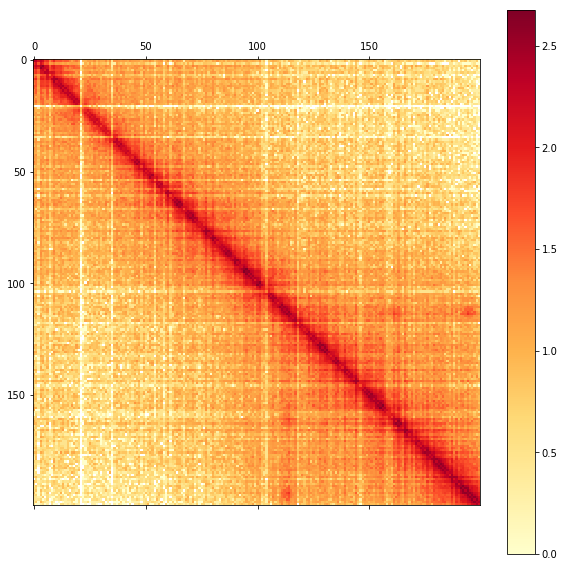

In [35]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(arr), cmap='YlOrRd')
fig.colorbar(im)

Notice the light and dark "banded" appearance? That's because you are looking at the unnormalized counts.

### Balancing your selection

We usually normalize or "correct" Hi-C using a technique called matrix balancing. This involves finding a set of weights or biases $b_i$ for each bin $i$ such that

$$ Normalized[i,j] = Observed[i,j] \cdot b[i] \cdot b[j], $$

such that the marginals (i.e., row/column sums) of the global contact matrix are flat and equal.

Cooler can store the pre-computed balancing weights in the bin table.

Here's one way to manually apply them to balance your selection.

In [36]:
# get the balancing weights as a numpy array
weights = c.bins()['weight']  # view
bias = weights[1000:1200]     # series
bias = bias.values            # array

# fetch a sparse matrix
mat = c.matrix(balance=False, sparse=True)[1000:1200, 1000:1200]

# apply the balancing weights
mat.data = bias[mat.row] * bias[mat.col] * mat.data

# convert to dense numpy array
arr = mat.toarray()

As a shortcut, we get the same result by passing **`balance=True`** to the matrix view constructor.

In [37]:
arr2 = c.matrix(balance=True, sparse=True)[1000:1200, 1000:1200].toarray()
np.allclose(arr, arr2, equal_nan=True)

True

/home/nezar/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


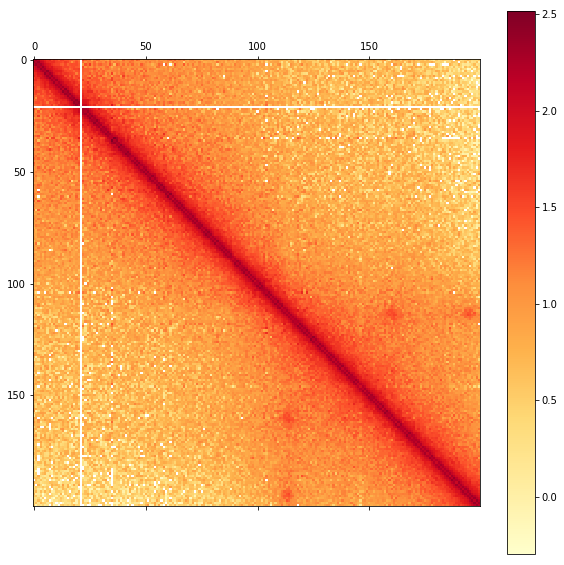

In [38]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(arr), cmap='YlOrRd')
fig.colorbar(im)

### Genomic coordinate range selection

The bin table, pixel table and matrix views also accept UCSC-style genomic range strings or (chrom, start, end) triples.

In [39]:
c.bins().fetch('chr2:10,000,000-20,000,000')

,chrom,start,end,weight
51851,chr2,10000000,10005000,2.474065
51852,chr2,10005000,10010000,1.403127
51853,chr2,10010000,10015000,0.883045
51854,chr2,10015000,10020000,0.771122
51855,chr2,10020000,10025000,0.924510
51856,chr2,10025000,10030000,0.866517
51857,chr2,10030000,10035000,1.014915
51858,chr2,10035000,10040000,1.052058
51859,chr2,10040000,10045000,1.311514
51860,chr2,10045000,10050000,0.965850


In [40]:
cis = c.matrix(sparse=True).fetch('chr21')
cis.shape

(9626, 9626)

In [41]:
trans = c.matrix(sparse=True).fetch('chr21', 'chr22')
trans.shape

(9626, 10261)